In [3]:
import pathlib
import numpy as np
import matplotlib.pylab as plt
from skimage import io
import seaborn as sns
%matplotlib inline

# Problem Analysis

Proba-V is a satellite, designed to take  come from an earth observation project.

It contains images with two resolutions in both the RED and NIR spectral band: 
#### 300m low-resolution images (LR).
Those images are taken every day. They are delivered as 128x128 grayscale image. 
#### 100m high resolution images (HR).
Approximately taken every 5 days. They are delivered as 384x384 grayscale images.

The objective of the challenge is to map the set of LR images to its HR counterpart. The particularity of the 
dataset is that some pixels in the image are concealed by observation noise. We are thus given a *quality map* under 
the form of a binary mask.  
 

# Data Exploration

In [6]:
p = pathlib.Path("/local/pajot/data/proba_v/")
p_train = p / 'train'
p_test = p / 'test'

p_red = p_train / 'RED'
p_nir = p_train / 'NIR'

list_path = list(p_nir.iterdir()) + list(p_red.iterdir())

In [7]:
def plot_low_res(list_path, num):
    fig, axs = plt.subplots(2, 8, figsize=(32, 8))
    i = 0
    
    for lr_path in list_path[num].glob('LR*.png'):
        im = io.imread(lr_path)
        m_path = pathlib.Path(str(lr_path).replace('LR', 'QM'))
        m = io.imread(m_path)
        
        axs[0, i].imshow(im)
        axs[0, i].axis('off')
        axs[1, i].imshow(m)
        axs[1, i].axis('off')
        i += 1
        if i > 7:
            break
    plt.show()
    
def plot_high_res(list_path, num):
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    i = 0
    p_hr = list_path[num] / 'HR.png'
    p_m = list_path[num] / 'SM.png'

    im = io.imread(p_hr)
    m = io.imread(p_m)
    
    axs[0].imshow(im)
    axs[0].axis('off')

    axs[1].imshow(m)
    axs[1].axis('off')

    
    plt.show()
    

We know show a random sample of low-resolution images and its corresponding masks.
Below is the corresponding high resolution image and its mask.

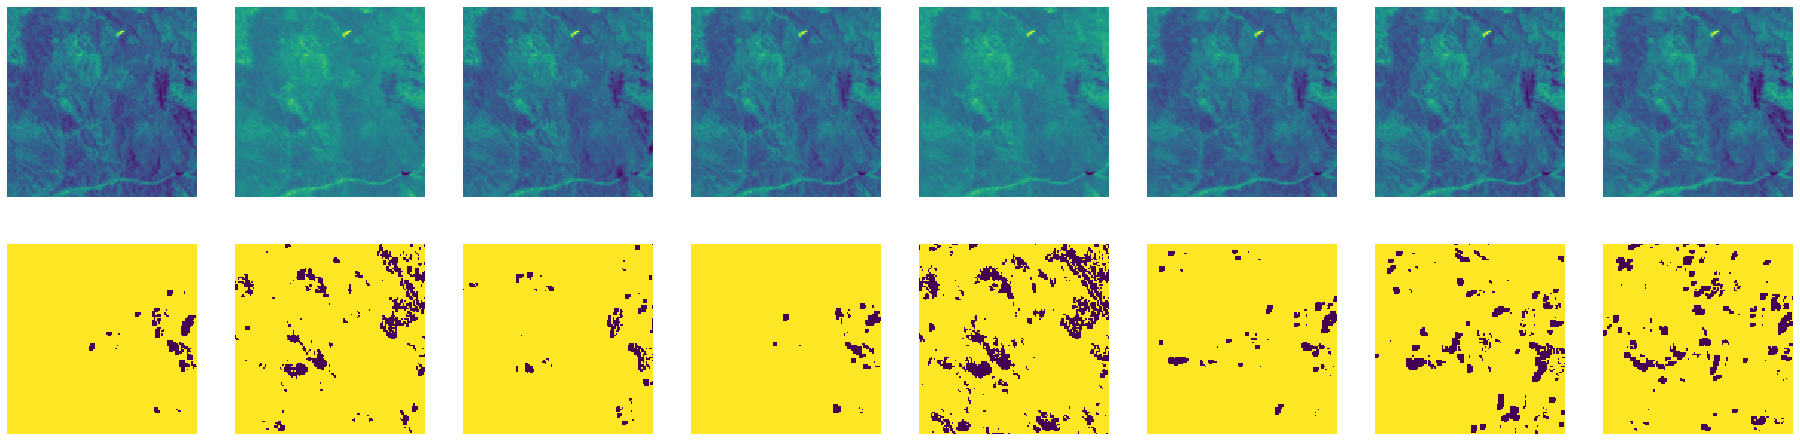

In [5]:
plot_low_res(list_path, 15)

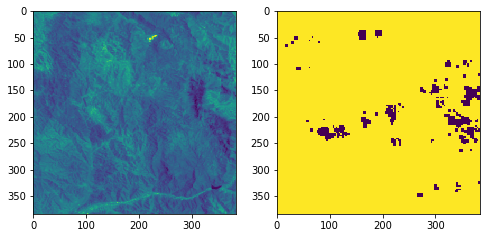

In [6]:
plot_high_res(list_path, 15)

## Dataset statistic

We hypothesize that the number of different low-resolution images per HR ones is key to a model performance.
We observe below that scenes have between 9 and 35 LR images, with a mean around 19. We observe as well that most of LR
images have a quality map with nearly 100% coverage. We could imagine a setting where we would remove scenes with few LR
images, or removing LR images with less than 95% coverage.

In [7]:
list_count = []
for imgset in list(p_nir.iterdir()) + list(p_red.iterdir()):
    list_SR = sorted(imgset.glob('LR*'))
    maxi = len(list_SR)
    list_count.append(maxi)
list_count = np.array(list_count)

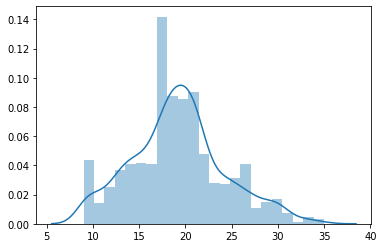

In [8]:
sns.distplot(list_count);

In [9]:
list_count = []
for imgset in list(p_nir.iterdir()) + list(p_red.iterdir()):
    list_QM = sorted(imgset.glob('QM*'))
    for i in list_QM:
        m = io.imread(i)
        count_m = m.sum() / 255
        list_count.append(count_m)
list_count = np.array(list_count)
list_count = list_count / (128 * 128)

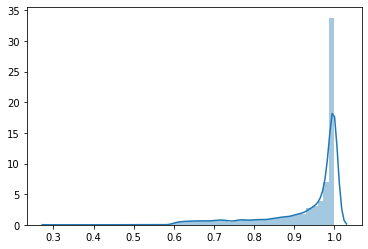

In [10]:
sns.distplot(list_count);

### Preprocessing

In order to speed up the training, we load all  the LR data beforehand and concatenate them in a numpy array. This preprocessing can be found 
can be found in file "script/"

# Approach Overview

As many Deep Learning Challenge, the score improvement can be separated in two categories. 
The first one is image preprocessing : how can we augment, transform or remove input data.
The second one is the model selection. 

# Data Processing

The way we handle the data is crucial for model performance. We present below some of the strategies we use.

## Two Strategies

In order to select the data, we chose to test two different strategies. Our model, as several classical DL model, 
must have a fixed number of channels as input. We present below two strategies to select $k$ pictures, which are then 
concatenated over the channel dimension.
#### Select k-best 

For this strategy, we select the $k$ least occluded lr images. 

#### Select k-random

For this strategy, we select the $k$


The implementation of this strategy can be found below :

In [11]:
def lr_sampler(lr, lr_mask, num_k, top=True):
    arr_percent_mask = lr_mask.sum(1).sum(1) / (128 * 128) # Percentage of masked pixels
    lr = lr[arr_percent_mask > 0] # Selecting only the frame that are not empty
    assert num_k < lr.shape[0] # num_k must be < 9
    if top:
        argsort_arr = np.argsort(arr_percent_mask)[::-1]
        lr = lr[argsort_arr[:num_k]]
        
    idx = np.random.choice(lr.shape[0], num_k)
    return lr[idx]


## Statistic Augmentation

Another way to resume information of all LR images is to aggregate its data.  We propose two types of aggregation : 
mean aggregation and median aggregation. 


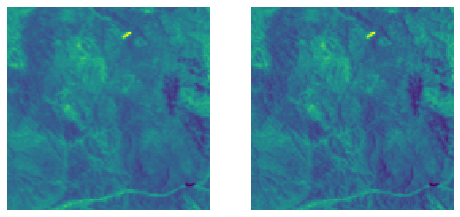

In [8]:
def plot_mean_med(list_path, num):
    fig, axs = plt.subplots(1, 2, figsize=(8, 8))
    i = 0
    l = []
    for lr_path in list_path[num].glob('LR*.png'):
        im = io.imread(lr_path)
        l.append(im)

    l = np.array(l)
    axs[0].imshow(np.mean(l, axis=0))
    axs[0].axis('off')

    axs[1].imshow(np.median(l, axis=0))
    axs[1].axis('off')
    plt.show()

plot_mean_med(list_path, 15)


# Model


## Model Overview
By model, we call the network architecture as well as the training algorithm. 

### Network architecture

The classical architecture for image translation task [2], such as super-resolution, is Resnet [3]. Instead of building a Resnet from scratch, 
we chose to choose an architecture from the extensive SR literature.

[Github link](https://github.com/xinntao/EDVR/blob/master/codes/models/archs/SRResNet_arch.py)

There exist several other models for image super-resolution :
 - [Second-Order Attention Network for Single Image Super-Resolution](http://openaccess.thecvf.com/content_CVPR_2019/html/Dai_Second-Order_Attention_Network_for_Single_Image_Super-Resolution_CVPR_2019_paper.html)
 - [ERSGAN](https://arxiv.org/pdf/1809.00219v2.pdf)
 - [A Fully Progressive Approach to Single-Image Super-Resolution](https://arxiv.org/abs/1804.02900v2)

Their strong performance, however, comes at the cost of high computing cost. It is the reason we chose not to use it.

### Loss function
As stated in [1], for super-resolution the choice of the model is driven by the choice of the objective function.

#### MSE
The standard reconstruction loss is MSE. We could also consider Charbonnier Loss, which could help generalizations. 
The scoring is made by PSN, which is a log transformation of the MSE.
 By construction, low MSE should lead to low PSNR. . 
 


#### GAN Loss 
MSE have a tendency to lose low-frequency details. As an alternative, we considered using an adversarial loss. 
An adversarial regularization approaches such as in [1,2] is a state-of-the-art approach to image super resolution. 
It allows more high-frequency details as well as a better perceptual quality. We use a GAN loss (see code). 
As we found it increased the computational cost. We choose instead to use SSIM. 

#### SSIM

Structural SIMilarity or SSIM is a measure between two images. It is perception based, meaning
 it considers image degradation as perceived change in structural information.
 
We use the differentiable implementation available at : https://github.com/VainF/pytorch-msssim

Our final loss is 

$$ L = L_{MSE} + \lambda * L_{SSIM} $$

The hyperparameters $\lambda$ is chosen by validating on a validation set.

### Optimizer

Adam, reduce lr on plateau.

In [ ]:
opt_g = torch.optim.Adam(self.gen.parameters(), lr=lrg, betas=(b1, b2))

scheduler = lr_scheduler.ReduceLROnPlateau(opt_g, mode='min', factor=0.98,
                                           verbose=True, patience=3)

Parameters, lrg, b1 and b2 are selected during parameters selection.

### Baseline improvement

At last, one simple trick allowed us to improve our score. Instead of directly predict the HR image,
 we generated a HR with bicubic interpolation. 
 Then instead of predicting the image, we learn the difference between the bicubic interpolated image and the true HR. 
It is done by simply summing the output of our network and the HR one, before computing the reconstruction loss.

## Model Selection and scoring

We perform a small random search in order to find the best parameters of our model. Hyperparameters include :

We used [Pytorch Lightning](https://github.com/williamFalcon/pytorch-lightning) to save and mange our experiments.
The retained using

It is interesting to note that our evaluation on the evaluation set had almost the same value as the evaluation on the test 
set. This shows that we didn't overfit the evaluation set, and that the train set and the test set have a very similar 
distribution.

In [ ]:
def cPSNR(sr, hr, mask):
    b = ((hr - sr) / mask.sum()).sum()
    cMSE = np.square(hr - (sr + b)).sum() / mask.sum()
    cPSNR = -10 * np.log10(cMSE)
    return cPSNR


def max_cPSNR(sr, hr, mask):
    size = 378
    sr = sr[3:size + 3, 3:size + 3]
    max_psnr = 0
    for i, j in itertools.product(range(6), range(6)):
        hr_small = hr[i:i + size, j:j + size]
        mask_small = mask[i:i + size, j:j + size]
        psnr = cPSNR(sr, hr_small, mask_small)
        if psnr > max_psnr:
            max_psnr = psnr
    return max_psnr

## Final Choice and results

Our final model given by parameter selection takes the 8 top clearer SR images as input. It adds the mean and the median 
to the input. We set the learning rate at $0.0004$. It allowed us to obtain a score of $0.983$ on the leaderboard.
As a matter of comparison, the same parameters with an adversarial loss and no *baseline improvement*, gave us a score 
of $1.004$

# Leads

Unfortunately, due to lack of time and of computation power, there is some idea that we haven't been able to explore. 
We are however confident it could improve the final score. 

## Deep Image Prior

[Deep Image Prior](https://dmitryulyanov.github.io/deep_image_prior) offers interesting methods for unsupervised
 image completion. She authors use a randomly initialized Neural Network as an image prior of image completion.
Given an input masked, a generator $G_\phi$ parameterized by random parameters $\phi$, and a random latent code $z$, 
the reconstruction $G_{\phi^*}(z)$ is obtained by resolving the following optimization problem:

\begin{equation}
\phi^* = arg min_\phi \left\Vert y - G_{\phi}(z)\right\Vert_2^2
\end{equation}


## Adversarial Image Augmentation

We also believe that the adversarial method described in [4] could improve further the unsupervised reconstruction 
capability as it has shown superior results compared to DIP. It requires, however, acess to samples of the corruption distribution
(the quality map). As we have enough map, applying a random one mask might work. 

It is a personal scientific publication.

## Image registration

Another characteristic of the data is that the LR images are not aligned. An interesting pre-processing could be to
realign them. Such process is called data registration, and there exists several python library that can perform this task.

https://pythonhosted.org/imreg_dft/quickstart.html#quickstart
https://simpleelastix.github.io/

One could even imagine a differentiable solution by computing the optical flow between all images.

# Bibliography

[1] Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network - *Christian Ledig, Lucas Theis, Ferenc Huszar, Jose Caballero, Andrew Cunningham, Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz, Zehan Wang, Wenzhe Shi*

[2] Image-to-Image Translation with Conditional Adversarial Nets - *Phillip Isola, Jun-Yan Zhu,Tinghui Zhou,Alexei A. Efros*

[3] Deep Residual Learning for Image Recognition - *Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun*

[3] Deep Residual Learning for Image Recognition - *Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun*
